### Objectives

First, create a graph representation of the information we have. 
This would be information about the elements, and the nodes. 
Using this, we will feed it into our SVM, or a Random Forest, and see from there onwards

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import re

import torch
import torch.nn as nn
import numpy as np
import ast
import io

import plotly.graph_objs as go

# Set up torch to use CUDA or MPS if either are available
device = torch.device('cuda:0')  if torch.cuda.is_available() else torch.device('mps:0') if torch.backends.mps.is_available() else torch.device('cpu')
torch.set_default_device(device)

USE_NEW_FEATURES = True
USE_ONLY_3D_CNN_FEATURES = True
TRAIN_SVM = False
TRAIN_RF = False

MLP_MODEL_PATH = './mlp_regressor.pth'
LOAD_MLP_MODEL = False
SAVE_MLP_MODEL = False

In [2]:
# n = pd.read_csv('./full_node_Table_.csv')
df = pd.read_csv('./full_Table_.csv')

In [3]:
def get_pca_transformation_and_scaled_dataset(dataset, x_principal_components):
    # Standardizing the features
    standardized_data = StandardScaler().fit_transform(dataset)

    # Perform PCA
    pca = PCA(n_components=x_principal_components)
    principal_components = pca.fit_transform(standardized_data)

    # Create a DataFrame with the principal components
    columns = [f'PC{i+1}' for i in range(x_principal_components)]
    principal_df = pd.DataFrame(data=principal_components, columns=columns)
    
    # Explained variance for each PC
    explained_var = pca.explained_variance_ratio_

    # Plot for explained variance of each PC
    fig1 = go.Figure(data=go.Bar(x=columns, y=explained_var, marker_color='darkred'))
    fig1.update_layout(title='Explained Variance by Each Principal Component',
                       xaxis_title='Principal Components',
                       yaxis_title='Explained Variance Ratio')
    fig1.show()

    # Plot for cumulative explained variance
    cumulative_var = explained_var.cumsum()
    fig2 = go.Figure(data=go.Scatter(x=columns, y=cumulative_var, marker_color='darkred'))
    fig2.update_layout(title='Cumulative Explained Variance by Principal Components',
                       xaxis_title='Principal Components',
                       yaxis_title='Cumulative Explained Variance Ratio')
    fig2.show()

    total_explained_variance = cumulative_var[-1]
    print(f"Total explained variance by the first {x_principal_components} principal components: {total_explained_variance:.2f}")

    return principal_df, pca


In [4]:
def feature_contribution_to_variance(pca, explained_var, feature_names, drop_angle_edge_contributions=True):
    # Transpose pca.components_ to align with explained_var for dot product
    feature_contributions = pca.components_.T ** 2
    total_feature_contributions = np.dot(feature_contributions, explained_var)

    if len(feature_names) != len(total_feature_contributions):
        raise ValueError("The number of features does not match the length of the contributions array.")

    # Create a DataFrame for contributions
    contributions_df = pd.DataFrame({
        'Feature': feature_names,
        'Contribution': total_feature_contributions * 100
    })

    # Drop 'Angle_X_X' or 'edge_X' contributions if flag is True
    if drop_angle_edge_contributions:
        # Regular expression for matching 'Angle_X_X' or 'edge_X'
        regex_pattern = r"^(Angle_\d+_\d+|edge_\d+)$"

        # Filter out rows where 'Feature' matches the pattern
        contributions_df = contributions_df[~contributions_df['Feature'].str.match(regex_pattern)]

    # Sort by contribution in descending order
    sorted_contributions = contributions_df.sort_values(by='Contribution', ascending=False)
    return sorted_contributions


In [5]:
def plot_feature_contributions(sorted_contributions):
    fig = go.Figure(data=go.Bar(
        x=sorted_contributions['Feature'],
        y=sorted_contributions['Contribution'],
        marker_color='darkblue'
    ))
    fig.update_layout(
        title='Percentage Contribution of Each Feature to Total Variance',
        xaxis_title='Features',
        yaxis_title='Percentage Contribution'
    )
    fig.show()

In [6]:
datafrac = 1
# This cell reads the data from the CSV file and cleans it up

if(USE_NEW_FEATURES):

    # Set pandas options to display all columns and rows
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)

    csv_file_path = 'full_Table_All_Cells_With_Angles_And_Edges_CLEANED.csv'
    buffer = io.StringIO()

    # Open and process the CSV file, to strip entries so that numbers aren't read as strings by read_csv and column names have no leading/trailing whitespaces
    with open(csv_file_path, 'r') as file:
        for line in file:
            cleaned_line = ','.join(cell.strip() for cell in line.split(','))
            buffer.write(cleaned_line + '\n')

    # Move the buffer cursor to the start
    buffer.seek(0)

    # Read the cleaned data into pandas
    data = pd.read_csv(buffer)
    edge_columns = [col for col in data.columns if col.startswith('edge_') and col.split('_')[-1].isdigit()]
    # Replace empty entries with 0 in these columns
    data[edge_columns] = data[edge_columns].fillna(0)

    # Not sure if these folder names are required for segregating the dataset, so for now dropping them
    # data = data.drop(columns=['folder_name_x', 'folder_name_x.1', 'folder_name_y'])
    data = data.drop(columns=['folder_name_x.1']) # 'folder_name_x' not dropping here, dropping in sample_data
    
    # Make each string in folder_name_y correspond to an integer instead
    unique_strings = data['folder_name_y'].unique()
    string_to_int_mapping = {string: i+1 for i, string in enumerate(unique_strings)}
    
    data['folder_name_y'] = data['folder_name_y'].replace(string_to_int_mapping)
    
    # For now, we aren't using the 555 channel either
    data = data.drop(columns=['element_pixel_intensity_555'])

    # These fields seem to be not implemented either:
    data = data.drop(columns=["Unnamed: 0_x", "x", "y" ,"z" ,"node_x" ,"degree_x" ,"vol_cc_x" ,"avg_PK_Of_element_x" ,"element_connectivity_x" ,"Unnamed: 0_y"])

    # The next few lines of code are to convert the degree_distribution column to columns labelled node_degree_0, node_degree_1, etc. till node_degree_MAX
    def str_to_dict(s):
        try:
            return ast.literal_eval(s)
        except ValueError:
            return {}
    # Apply the function to the 'degree_distribution' column
    data['degree_distribution'] = data['degree_distribution'].apply(str_to_dict)
        
    # Find the highest node degree in the DataFrame
    max_degree = max(degree for row in data['degree_distribution'] for degree in row.keys())

    # Create a DataFrame for new columns
    new_columns = pd.DataFrame({f'node_degree_{i}': 0 for i in range(1, max_degree + 1)}, index=data.index)

    # Concatenate with the original DataFrame
    data = pd.concat([data, new_columns], axis=1)
        
    # Function to update the degree columns for a row
    def update_degrees(row):
        for degree, count in row['degree_distribution'].items():
            row[f'node_degree_{degree}'] = count
        return row

    # Apply the function to each row
    data = data.apply(update_degrees, axis=1)
    data = data.drop(columns=['degree_distribution'])
    # Now we should have columns labelled node_degree_0, node_degree_1, etc. till node_degree_MAX and dropped the degree_distribution column

    data['cc_average_connectivity'] = data['cc_average_connectivity'].replace([np.inf, -np.inf], 0)

    # Drop rows that have NaN values in columns 'clustering coefficient', 'pixel_intensity_ratio', 'vol_cc_y', 'x_y', 'y_y', 'z_y'
    # data = data.dropna(subset=['clustering coefficient', 'pixel_intensity_ratio', 'vol_cc_y', 'x_y', 'y_y', 'z_y'])

    # data['element_pixel_intensity_488'] = data['element_pixel_intensity_488'].replace(0, 0.001)
    # drop 0 values of 488, those rows are just bad
    data['element_pixel_intensity_488'] = data['element_pixel_intensity_488'].replace(0, np.nan)
    data = data.dropna(subset=['element_pixel_intensity_488'])
    
    data['element_pixel_intensity_405_488_ratio'] = ((np.array(data['element_pixel_intensity_405']) / np.array(data['element_pixel_intensity_488']))*1000).copy()

    # Add feature vectors from CNN obtained image vectors
    feature_vectors_df = pd.read_csv('image_feature_vectors.csv')
    data['image_name'] = data['folder_name_x'] + '_' + data['cc_x'].astype(str)
    data = pd.merge(data, feature_vectors_df, left_on='image_name', right_on='Image Name', how='left')
    data.drop('Image Name', axis=1, inplace=True)
    data.drop('image_name', axis=1, inplace=True)
    
    if(USE_ONLY_3D_CNN_FEATURES):
        angle_columns = data.filter(regex='^Angle_\d+_\d+$').columns
        edge_columns = data.filter(regex='^edge_\d+$').columns
        columns_to_drop = angle_columns.union(edge_columns).union(['Angle_Flag'])
        data.drop(columns=columns_to_drop, inplace=True)
    
    # Replace any remaining NaN's with 0
    data.fillna(0, inplace=True)

    # Train on small subset of data to see if it works first, if datafrac <1
    sample_data = data.sample(frac=datafrac ,random_state=1049)
    sample_data = sample_data.drop(columns=['folder_name_x'])
    

    # Split the data into training and testing sets
    X = sample_data.drop(columns=['element_pixel_intensity_488'])
    X = X.drop(['cc_pixel_intensity_488',
                'cc_pixel_intensity_405',
                'cc_x', 'x_y', 'y_y', 'z_y', 'cc_y',
                'pixel_intensity_405',
                'pixel_intensity_ratio',
                # 'pixel_intensity_555',
                'element_pixel_intensity_405',
                'element_pixel_intensity_ratio',
                'cc_average_connectivity',
                # 'cc_pixel_intensity_555',
                'cc_pixel_intensity_ratio', 
                'pixel_intensity',
                'pixel_intensity_488'], axis=1)
    
    xlabels = X.columns
    with open("training_feature_list_excl_angles_and_edges.txt", "w") as file:
        for thing in xlabels:
            if "Angle" not in thing and "edge" not in thing:
                file.write(thing + "\n")
    
    columns_with_NaN = sample_data.columns.to_series()[sample_data.apply(lambda x: np.isnan(x).any())]
    if(len(columns_with_NaN) > 0):
        print(columns_with_NaN.values)
        raise Exception('Columns with NaN values found in dataset, can\'t train model on it directly')
    
    non_numerical_columns = sample_data.select_dtypes(exclude=['int', 'float', 'double']).columns
    # Print the non-numerical column names
    if(len(non_numerical_columns) > 0):
        print(non_numerical_columns)
        raise Exception('Non-numerical columns found in dataset, can\'t train model on it directly')
    
    # Print any columns with values like infinity
    columns_with_infinity = sample_data.columns.to_series()[sample_data.apply(lambda x: np.isinf(x).any())]
    if(len(columns_with_infinity) > 0):
        print(columns_with_infinity)
        raise Exception('Columns with infinity values found in dataset, can\'t train model on it directly')

C:\Users\Biratal\AppData\Local\Temp\ipykernel_516\2153270007.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['element_pixel_intensity_405_488_ratio'] = ((np.array(data['element_pixel_intensity_405']) / np.array(data['element_pixel_intensity_488']))*1000).copy()
C:\Users\Biratal\AppData\Local\Temp\ipykernel_516\2153270007.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['image_name'] = data['folder_name_x'] + '_' + data['cc_x'].astype(str)


In [7]:
# Adding a new column for file names in the DataFrame
data['file_name'] = data.apply(lambda row: f"{row['folder_name_x']}_{row['cc_x']}.tif", axis=1)

# Selecting only the required columns
output_data = data[['file_name', 'cc_pixel_intensity_ratio']]

# Writing the selected data to a CSV file
output_data.to_csv("./imageNames_ratios.csv", index=False)

print("Data successfully written to ./imageNames_ratios.csv")


Data successfully written to ./imageNames_ratios.csv


In [8]:
if(USE_NEW_FEATURES):
    # X_transformed_pca, dataset_pca_sklearn_obj = get_pca_transformation_and_scaled_dataset(X, 256)
    # now without the insane number of features from the sparse matrix from Angle_x_y and edge_x, there are only 184 features
    # because we are now using the CNN image vectors
    
    X_transformed_pca, dataset_pca_sklearn_obj = get_pca_transformation_and_scaled_dataset(X, 184)
    
    explained_var = dataset_pca_sklearn_obj.explained_variance_ratio_

    # Calculate and sort feature contributions
    feature_contributions = feature_contribution_to_variance(dataset_pca_sklearn_obj, explained_var, X.columns)
    plot_feature_contributions(feature_contributions)
    
    # We're basically predicting
    # (405 / 488) * 1000

    Y = sample_data['element_pixel_intensity_405_488_ratio']

    # Perform standardization on X and Y
    # scalerX = StandardScaler()
    # scalerY = StandardScaler()

    y = np.rint(Y).astype(int)
    # 39 is the best) 
    X_train, X_test, y_train, y_test = train_test_split(X_transformed_pca, y, test_size=0.2, random_state=39)

    print("The training data shapes are:", X_train.shape, y_train.shape, "and the testing data shapes are:", X_test.shape, y_test.shape)
    print("The cumulative contributions of all features to the variation is:", feature_contributions['Contribution'].sum(), "%")

Total explained variance by the first 184 principal components: 1.00


The training data shapes are: (9644, 184) (9644,) and the testing data shapes are: (2412, 184) (2412,)
The cumulative contributions of all features to the variation is: 99.99999999999997 %


In [ ]:
X_train

In [9]:
def plot_error_frequency(y_pred, y_test, classifier_title, rounding):
    rounding_ = rounding//2
    
    # Calculate errors
    errors = (abs(y_pred - y_test) < rounding_)

    # Extract labels where errors occurred
    error_labels = y_test[errors]

    # Calculate frequency of each label
    unique_labels, counts = np.unique(error_labels, return_counts=True)

    # Creating a dictionary of label frequencies for errors
    label_error_frequency = dict(zip(unique_labels, counts))

    # Finding the range of all possible labels (from min to max in y_test and y_pred)
    all_labels = np.unique(np.concatenate((y_test, y_pred)))
    min_label = min(all_labels)
    max_label = max(all_labels)

    # Filling in frequencies for labels that did not have errors
    for label in range(min_label, max_label + 1):
        if label not in label_error_frequency:
            label_error_frequency[label] = 0

    # Sorting the dictionary for plotting
    sorted_label_error_frequency = dict(sorted(label_error_frequency.items()))

    xticks = np.arange(min_label, max_label + 1, 50)

    # Plotting the error frequency
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_label_error_frequency.keys(), sorted_label_error_frequency.values())
    plt.xlabel('Prediction')
    plt.ylabel('Error Frequency')
    plt.title('Error Frequency Distribution for ' + str(classifier_title) + ' for errors >= {} ({} in either direction)'.format(rounding, rounding_))
    plt.xticks(xticks, rotation='vertical')  # Set x-ticks to show every 50th label and rotate them vertically
    plt.show()

    # Calculating mean and standard deviation of absolute errors
    absolute_errors = np.abs(y_pred - y_test)
    mean_error = np.mean(absolute_errors)
    std_error = np.std(absolute_errors)
    print("The mean error is", mean_error, "and the standard deviation of the errors is", std_error)

    # Plotting absolute error for each label
    plt.figure(figsize=(10, 6))
    for label in all_labels:
        label_errors = absolute_errors[y_test == label]
        plt.bar([label]*len(label_errors), label_errors, color='r')
    plt.xlabel('Prediction')
    plt.ylabel('Absolute Error')
    plt.title('Absolute Error for Each Label in ' + str(classifier_title))
    plt.xticks(xticks, rotation='vertical')
    plt.show()


In [10]:
def calculate_accuracy(y_test, y_pred, rounding):
    y_test = y_test.values
    rounding = rounding//2
    # print(y_pred)
    assert(len(y_test) == len(y_pred))
    num_predictions = len(y_test)
    num_correct_predictions = 0
    for i in range(len(y_test)):
        if abs(y_test[i] - y_pred[i]) <= rounding:
            num_correct_predictions += 1
    
    return num_correct_predictions/num_predictions

In [11]:
# For y_train and y_test, round down to nearest 10
# y_train = (np.floor(y_train / 10) * 10).astype(int)
# y_test = (np.floor(y_test / 10) * 10).astype(int)

# Noticed weird behaviour with SVM:
# If y_train and y_test are not rounded down to nearest 10,
# then the training takes LONGER (it just wouldn't finish training on my mac)
# even though it means there are 10 times fewer classifiers to train?
# (also yes, doing that means the output would not be a regression but a classification,
# and outputs would be classified into groups of 10, as in the model would tell you whether the
# functional parameter is between 0-10, 10-20, 20-30, etc.)

# Also it was not possible to get the SVM to train on my MAC for datasets above 10k rows (10k including training and testing split)
# Training just never finished if I tried that, even if I left it running overnight.

# This makes sense though because with more classes (i.e discrete functional parameter values in this case),
# the training time grows quadratically as that many more classifiers need to be trained.

# print(y_train, y_test)

if(TRAIN_SVM):

    svm_model = SVC(kernel='linear')  # You can choose different kernels like 'rbf', 'poly', etc.
    svm_model.fit(X_train, y_train)


    y_pred = svm_model.predict(X_test)

    print(pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}))

    rounding = 50

    accuracy = calculate_accuracy(y_test, y_pred, rounding)
    classification_rep = classification_report(y_test, y_pred)

    plt.plot(y_test, y_pred, 'o')
    plt.title('Accuracy: ' + str(accuracy) + ' with rounding factor ' + str(rounding))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    y_pred_svm = y_pred
    
    # Create a DataFrame with the test and pred values
    df = pd.DataFrame({'Test': y_test, 'Pred': y_pred_svm})

    # Save the DataFrame to a CSV file
    df.to_csv('svm_test_pred.csv', index=False)


In [12]:
if(TRAIN_SVM):
    plot_error_frequency(y_pred_svm, y_test, 'SVC', rounding)

In [13]:
if(TRAIN_RF):

    # do the same for random forest
    from sklearn.ensemble import RandomForestClassifier

    rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, random_state=0)
    rf_model.fit(X_train, y_train)

    rounding = 50
    
    y_pred = rf_model.predict(X_test)
    accuracy = calculate_accuracy(y_test, y_pred, rounding)

    plt.plot(y_test, y_pred, 'o')
    plt.xlabel("Actual value")
    plt.ylabel("Predicted value")
    plt.title('Accuracy: {} with rounding factor {}'.format(accuracy, rounding))

    y_pred_rf = y_pred
    
    # Create a DataFrame with the test and pred values
    df = pd.DataFrame({'Test': y_test, 'Pred': y_pred_rf})

    # Save the DataFrame to a CSV file
    df.to_csv('rf_test_pred.csv', index=False)

In [14]:
if(TRAIN_RF):
    plot_error_frequency(y_pred_rf, y_test, 'Random Forest', rounding)

In [15]:

# Used the plotly library as this is much nicer looking, and the graph is more interactive and works well with Jupyter Notebooks

def plot_absolute_error_plotly(y_pred_model1, y_pred_model2, y_test, model_title1, model_title_2):
    def calculate_error_frequency(y_pred):
        incorrect = y_pred != y_test

        unique_predictions, counts = np.unique(y_pred[incorrect], return_counts=True)
        error_freq = dict(zip(unique_predictions, counts))

        return error_freq

    error_freq_svc = calculate_error_frequency(y_pred_model1)
    error_freq_rf = calculate_error_frequency(y_pred_model2)

    all_labels = np.unique(np.concatenate((y_pred_model1, y_pred_model2)))
    all_labels.sort()

    svc_freq = [error_freq_svc.get(label, 0) for label in all_labels]
    rf_freq = [error_freq_rf.get(label, 0) for label in all_labels]

    fig = go.Figure(data=[
        go.Bar(name=model_title1, x=all_labels, y=svc_freq),
        go.Bar(name=model_title_2, x=all_labels, y=rf_freq)
    ])

    fig.update_layout(
        barmode='group',
        title='Prediction Error Frequency',
        xaxis_title='Predicted Label',
        yaxis_title='Frequency of Incorrect Predictions',
        xaxis=dict(type='category')
    )

    fig.show()


def plot_error_label_frequency_plotly(y_pred_model1, y_pred_model2, y_test, model_title1, model_title2):
    labels = np.unique(y_test)
    errors_svc = [np.sum((y_pred_model1 != y_test) & (y_test == label)) for label in labels]
    errors_rf = [np.sum((y_pred_model2 != y_test) & (y_test == label)) for label in labels]

    bar_width = max(0.5, 30 / len(labels))

    fig = go.Figure(data=[
        go.Bar(name=model_title1, x=labels, y=errors_svc, width=bar_width, marker_color='blue', marker_line_color='blue', marker_line_width=1.5, opacity=1),
        go.Bar(name=model_title2, x=labels, y=errors_rf, width=bar_width, marker_color='red', marker_line_color='red', marker_line_width=1.5, opacity=1)
    ])
    
    fig.update_layout(
        barmode='group',
        title='Error Frequency per Label',
        xaxis_title='Labels',
        yaxis_title='Number of Errors',
        xaxis=dict(tickmode='array', tickvals=labels[::10]),
        plot_bgcolor='rgba(255, 255, 255, 1)',
        font=dict(
            size=12,  # You can adjust the size of the text here for better visibility
        )
    )
    fig.show()


In [16]:
if(TRAIN_RF and TRAIN_SVM):
    plot_absolute_error_plotly(y_pred_svm, y_pred_rf, y_test, 'SVC', 'Random Forest')
    plot_error_label_frequency_plotly(y_pred_svm, y_pred_rf, y_test, 'SVC', 'Random Forest')

In [17]:
# Data distribution
# Basically plot the frequency of ocurrence of each value
# of the functional parameter in the dataset inputted to the models

# This is only plotting the subset in the training set, and not in the entire dataset

def plot_data_distribution(y):
    # Calculate the frequency of each value in the y_test array
    unique_values, counts = np.unique(y, return_counts=True)

    # Create the bar chart
    fig = go.Figure(data=go.Bar(x=unique_values, y=counts))

    # Update the layout for a better visual representation
    fig.update_layout(
        title='Data Distribution',
        xaxis_title='Unique Values',
        yaxis_title='Frequency',
        xaxis=dict(type='category'),  # Treat unique values as discrete categories
        yaxis=dict(title='Frequency'),  # You can also set the range or scale of the y-axis if needed
    )

    fig.show()
    print("The mean of the data distribution is", np.mean(y_train), "and the standard deviation is", np.std(y_train))

In [21]:
X_train

KeyboardInterrupt: 

In [19]:
# Define the MLP regressor class
class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the MLP regressor
input_size = X_train.shape[1]
# hidden_size = int((X_train.shape[1] + 1) / 2)
hidden_size = input_size
mlp_regressor = MLPRegressor(input_size, hidden_size).to(device)
if(LOAD_MLP_MODEL):
    try:
        mlp_regressor.load_state_dict(torch.load(MLP_MODEL_PATH))
    except Exception as e:
        print("Couldn't load model")
        print(e)

# Define the loss function and optimizer
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(mlp_regressor.parameters(), lr=0.001, weight_decay=1e-5)

def create_batches(X, Y, batch_size):
    num_batches = int(np.ceil(X.shape[0] / batch_size))
    batches = []

    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        X_batch = X[start:end]
        Y_batch = Y[start:end]
        batches.append((X_batch, Y_batch))

    return batches

# Train the MLP regressor
def train_mlp_regressor(regressor, optimizer, epochs, batch_size, X_train, Y_train):
    # Convert the training data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

    # Create manual batches
    train_batches = create_batches(X_train_tensor, Y_train_tensor, batch_size)

    for epoch in range(epochs):
        for X_batch, Y_batch in train_batches:
            # Move batch to the device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            # Forward pass
            outputs = regressor(X_batch)
            loss = criterion(outputs, Y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        
def test_mlp_regressor(regressor, X_test, Y_test):
    # Convert the testing data to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).squeeze()

    # Test the MLP regressor
    with torch.no_grad():
        outputs = regressor(X_test_tensor)
        loss = criterion(outputs, Y_test_tensor)
        print(f'Loss: {loss.item():.4f}')
        
    # Convert the predictions to a NumPy array
    return outputs.cpu().detach().numpy().squeeze()

In [20]:
if(not LOAD_MLP_MODEL):
    train_mlp_regressor(mlp_regressor, optimizer, epochs=7000, batch_size=500, X_train=X_train.values if isinstance(X_train, pd.DataFrame) else X_train, Y_train=np.array(y_train).reshape(-1, 1))
# Interrupt this cell whenever it feels like this model has trained enough

Epoch [10/7000], Loss: 16.2984
Epoch [20/7000], Loss: 9.6234
Epoch [30/7000], Loss: 3.9739
Epoch [40/7000], Loss: 2.3856
Epoch [50/7000], Loss: 1.6149
Epoch [60/7000], Loss: 1.3673
Epoch [70/7000], Loss: 1.0768
Epoch [80/7000], Loss: 0.9388
Epoch [90/7000], Loss: 0.9548
Epoch [100/7000], Loss: 0.7581
Epoch [110/7000], Loss: 0.6749
Epoch [120/7000], Loss: 0.4809
Epoch [130/7000], Loss: 0.8089
Epoch [140/7000], Loss: 0.5573
Epoch [150/7000], Loss: 0.4476
Epoch [160/7000], Loss: 0.4873
Epoch [170/7000], Loss: 0.3349
Epoch [180/7000], Loss: 0.3804
Epoch [190/7000], Loss: 0.4048
Epoch [200/7000], Loss: 0.2965
Epoch [210/7000], Loss: 0.3245
Epoch [220/7000], Loss: 0.2208
Epoch [230/7000], Loss: 0.2145
Epoch [240/7000], Loss: 0.4450
Epoch [250/7000], Loss: 0.2475
Epoch [260/7000], Loss: 0.2828
Epoch [270/7000], Loss: 0.2434
Epoch [280/7000], Loss: 0.2339
Epoch [290/7000], Loss: 0.2296
Epoch [300/7000], Loss: 0.3881
Epoch [310/7000], Loss: 0.2422
Epoch [320/7000], Loss: 0.2051
Epoch [330/7000]

KeyboardInterrupt: 

In [ ]:
# Save model to disk
if(SAVE_MLP_MODEL):
    torch.save(mlp_regressor.state_dict(), MLP_MODEL_PATH)

Loss: 70.5236


c:\Users\Biratal\miniconda3\Lib\site-packages\torch\utils\_device.py:77: UserWarning:

Using a target size (torch.Size([2412])) that is different to the input size (torch.Size([2412, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Text(0.5, 1.0, 'Accuracy (prediction error < 50): 0.9867330016583747')

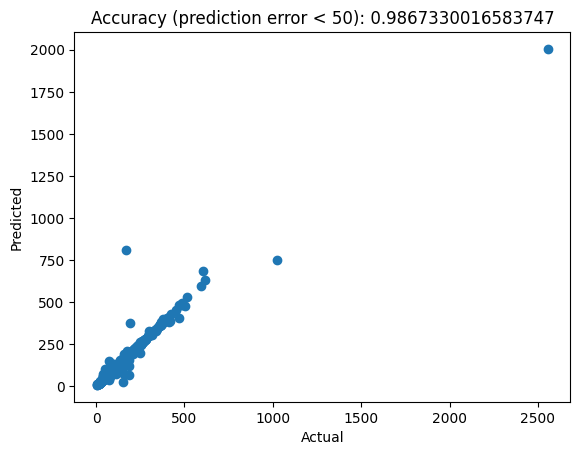

In [ ]:

y_pred_mlp = test_mlp_regressor(mlp_regressor, X_test.values if isinstance(X_test, pd.DataFrame) else X_test, np.array(y_test).reshape(-1, 1).squeeze())
y_pred_mlp = np.rint(y_pred_mlp).astype(int)

rounding_graph = 1
rounding = 50

plt.plot(np.floor(y_test//rounding_graph) * rounding_graph, np.floor(y_pred_mlp//rounding_graph) * rounding_graph, 'o')
# accuracy = accuracy_score(np.floor(y_test//rounding) * rounding, np.floor(y_pred_mlp//rounding) * rounding)
accuracy = calculate_accuracy(y_test, y_pred_mlp, rounding)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Accuracy (prediction error < {}): {}'.format(rounding, accuracy))

In [ ]:

# y_pred_mlp = test_mlp_regressor(X_train.values if isinstance(X_train, pd.DataFrame) else X_train, np.array(y_train).reshape(-1, 1).squeeze())
# y_pred_mlp = np.rint(y_pred_mlp).astype(int)

# rounding = 10

# plt.plot(np.floor(y_train//rounding) * rounding, np.floor(y_pred_mlp//rounding) * rounding, 'o')
# accuracy = accuracy_score(np.floor(y_train//rounding) * rounding, np.floor(y_pred_mlp//rounding) * rounding)

# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Accuracy (within nearest {}): {}'.format(rounding, accuracy))

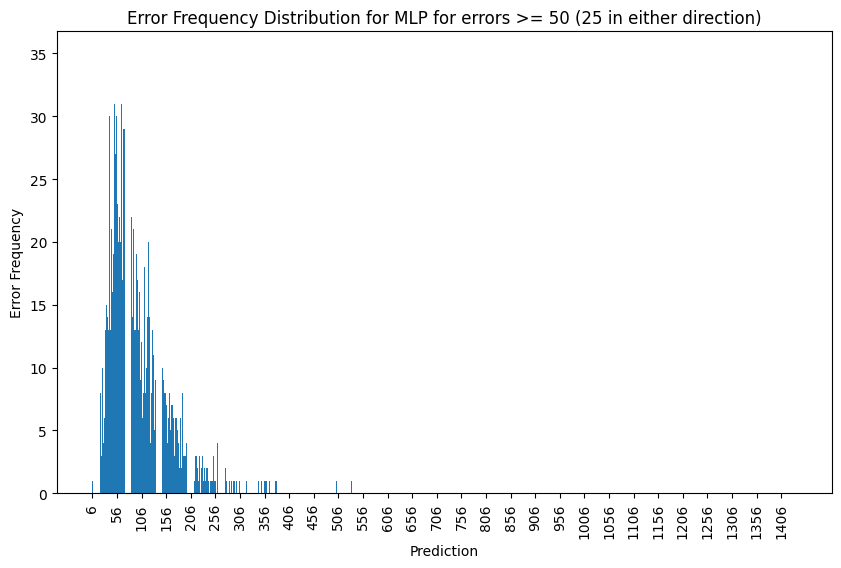

The mean error is 1.9191542288557213 and the standard deviation of the errors is 13.774408985503808


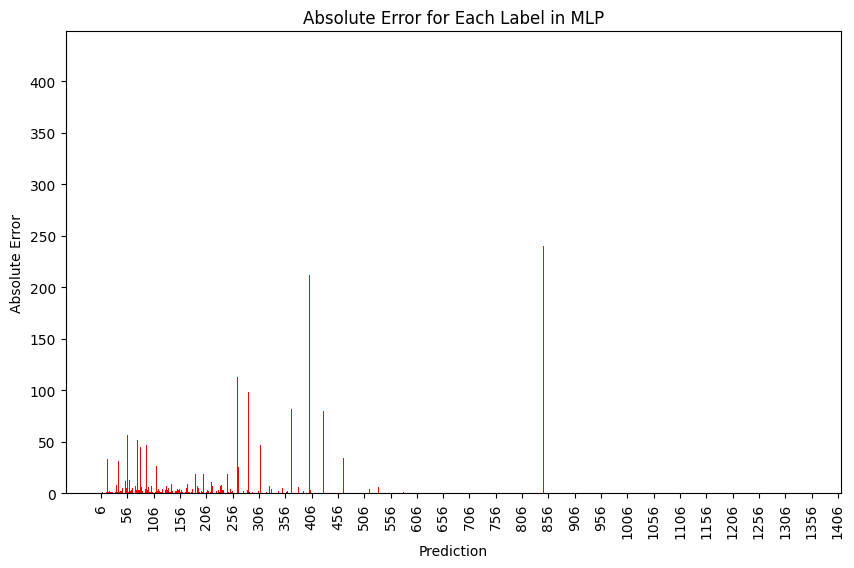

In [ ]:
plot_error_frequency(y_pred_mlp, y_test, 'MLP', rounding)

In [ ]:
plot_data_distribution(y)

The mean of the data distribution is 106.15045624222314 and the standard deviation is 86.69586631438048


In [ ]:
# Create a DataFrame with the test and pred values
df = pd.DataFrame({'Test': y_test, 'Pred': y_pred_mlp})

# Save the DataFrame to a CSV file
df.to_csv('mlp_test_pred.csv', index=False)

In [ ]:
# # split data into different bins, one for data below y <= 250 and one for data y > 250.
# # then, for bin y <= 250, split into test and train sets. do the same for bin y > 250.
# # train 2 different MLP models based on MLP regressor module. graph out the results after all this.

# # X, Y are the full data set

# # splitting the data into bins of y <=250 and y > 250

# # print(X.shape, Y.shape)

# # print(Y <= 250)

# X_bin_1 = X[Y.values <= 250]
# Y_bin_1 = Y[Y.values <= 250]

# X_bin_2 = X[Y.values > 250]
# Y_bin_2 = Y[Y.values > 250]

# # splitting the data into test and train sets
# X_bin_1_train, X_bin_1_test, Y_bin_1_train, Y_bin_1_test = train_test_split(X_bin_1, Y_bin_1, test_size=0.2, random_state=42)
# X_bin_2_train, X_bin_2_test, Y_bin_2_train, Y_bin_2_test = train_test_split(X_bin_2, Y_bin_2, test_size=0.2, random_state=42)

# # training the MLP models
# mlp_regressor_bin_1 = MLPRegressor(input_size, hidden_size).to(device)
# mlp_regressor_bin_2 = MLPRegressor(input_size, hidden_size).to(device)

# # optimizers for both the bins
# optimizer_bin_1 = torch.optim.Adam(mlp_regressor_bin_1.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer_bin_2 = torch.optim.Adam(mlp_regressor_bin_2.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
# # print(mlp_regressor_bin_1)
# # for x in X_bin_1_train.values:
# #     for i in x:
# #         print(i, end=' ')
# #     print("")
# # print(Y_bin_1_train.values)

# train_mlp_regressor(mlp_regressor_bin_1, optimizer_bin_1, epochs=4000, batch_size=500, X_train=X_bin_1_train.values if isinstance(X_bin_1_train, pd.DataFrame) else X_bin_1_train, Y_train=np.array(Y_bin_1_train).reshape(-1, 1))

In [ ]:
# train_mlp_regressor(mlp_regressor_bin_2, optimizer_bin_2, epochs=10000, batch_size=500, X_train=X_bin_2_train.values if isinstance(X_bin_2_train, pd.DataFrame) else X_bin_2_train, Y_train=np.array(Y_bin_2_train).reshape(-1, 1))

NameError: name 'mlp_regressor_bin_2' is not defined

/Users/rithikkumars/miniconda3/envs/kasturi_ml_project/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning:

Using a target size (torch.Size([2324])) that is different to the input size (torch.Size([2324, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Loss: 57.2262
Loss: 214.3464


/Users/rithikkumars/miniconda3/envs/kasturi_ml_project/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning:

Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



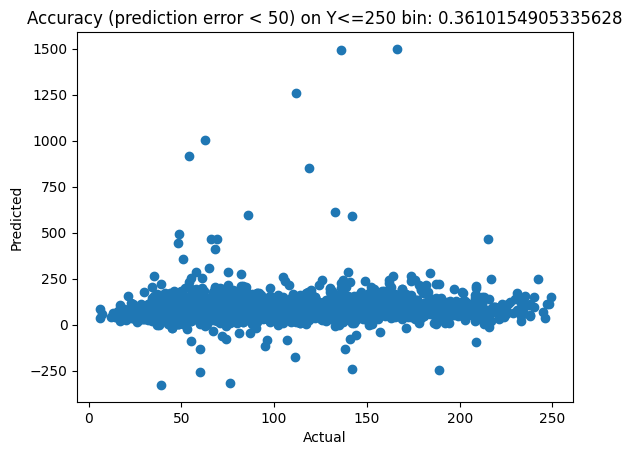

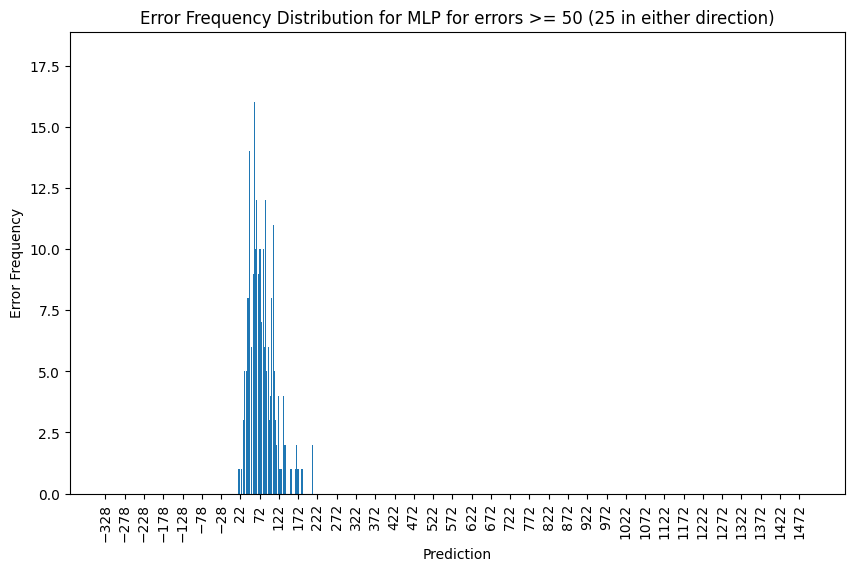

The mean error is 52.59724612736661 and the standard deviation of the errors is 72.61028475339208


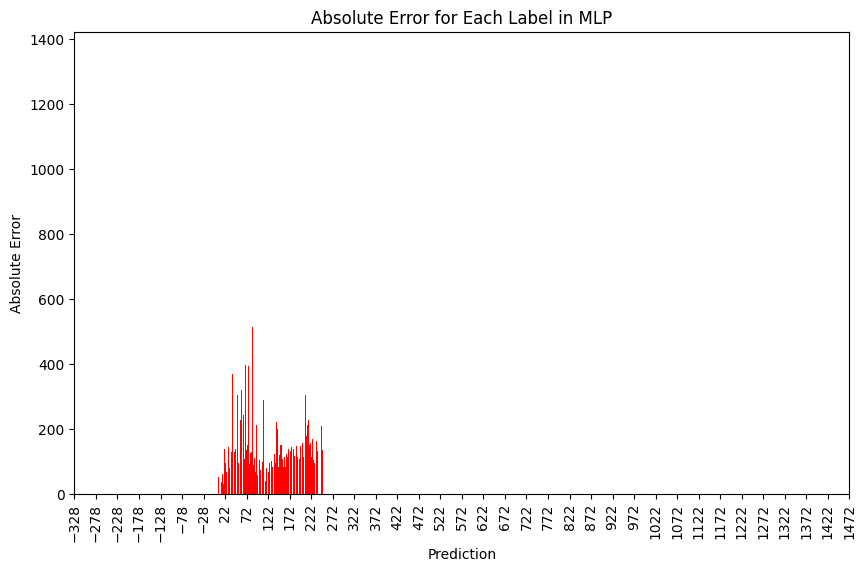

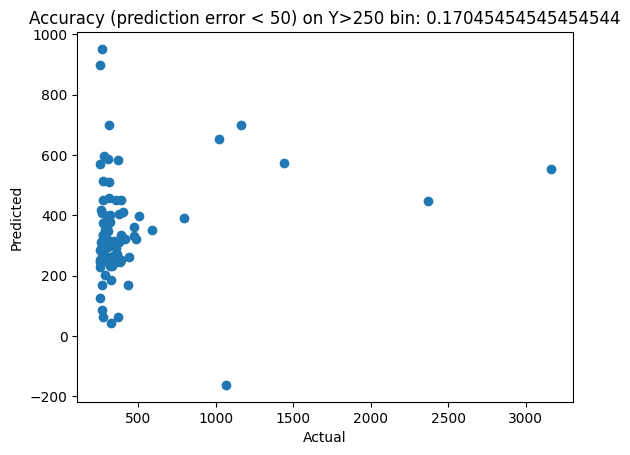

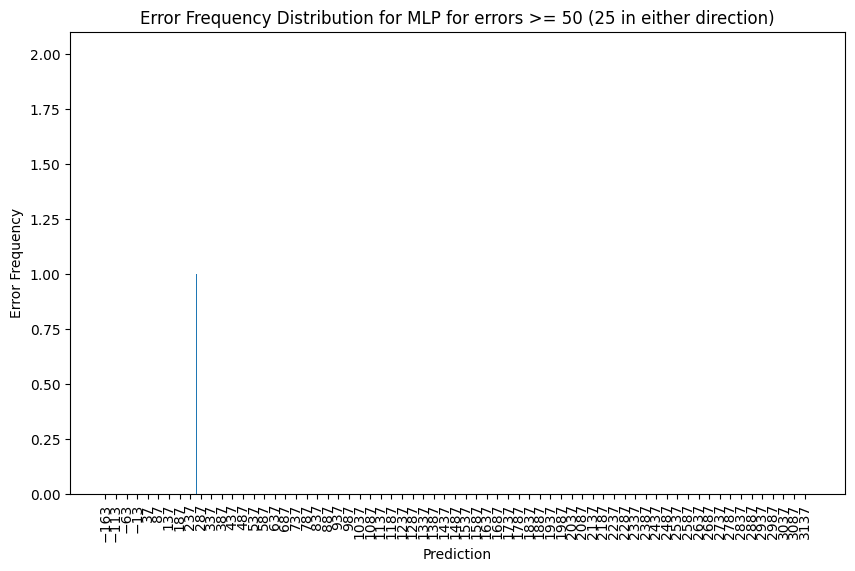

The mean error is 195.0340909090909 and the standard deviation of the errors is 372.3754352087431


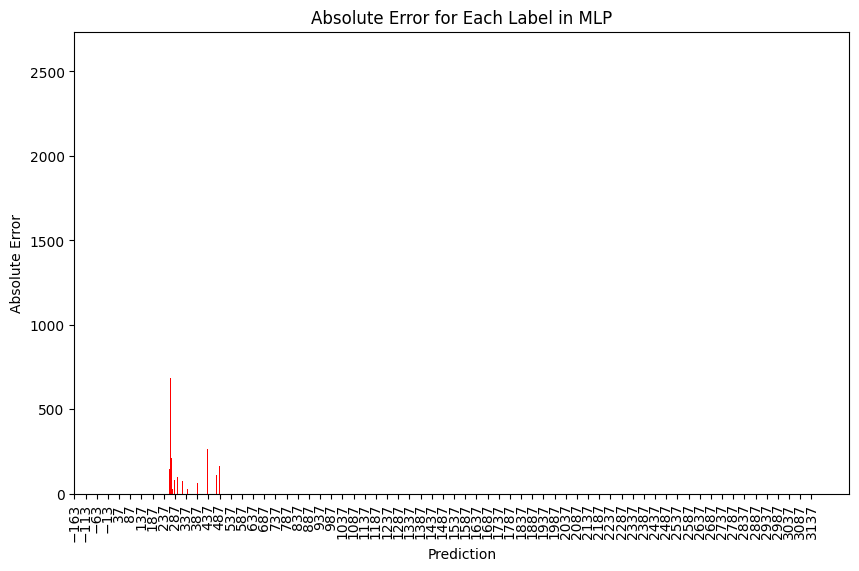

In [ ]:

# # testing the MLP models
# y_pred_mlp_bin_1 = test_mlp_regressor(mlp_regressor_bin_1, X_bin_1_test.values if isinstance(X_bin_1_test, pd.DataFrame) else X_bin_1_test, np.array(Y_bin_1_test).reshape(-1, 1).squeeze())
# y_pred_mlp_bin_1 = np.rint(y_pred_mlp_bin_1).astype(int)

# y_pred_mlp_bin_2 = test_mlp_regressor(mlp_regressor_bin_2, X_bin_2_test.values if isinstance(X_bin_2_test, pd.DataFrame) else X_bin_2_test, np.array(Y_bin_2_test).reshape(-1, 1).squeeze())
# y_pred_mlp_bin_2 = np.rint(y_pred_mlp_bin_2).astype(int)

# Y_bin_1_test = np.rint(Y_bin_1_test).astype(int)
# Y_bin_2_test = np.rint(Y_bin_2_test).astype(int)

# # plotting the results
# plt.plot(np.floor(Y_bin_1_test//rounding_graph) * rounding_graph, np.floor(y_pred_mlp_bin_1//rounding_graph) * rounding_graph, 'o')
# accuracy_bin1 = calculate_accuracy(Y_bin_1_test, y_pred_mlp_bin_1, rounding)

# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Accuracy (prediction error < {}) on Y<=250 bin: {}'.format(rounding, accuracy_bin1))
# plot_error_frequency(y_pred_mlp_bin_1, Y_bin_1_test, 'MLP', rounding)

# plt.plot(np.floor(Y_bin_2_test//rounding_graph) * rounding_graph, np.floor(y_pred_mlp_bin_2//rounding_graph) * rounding_graph, 'o')
# accuracy_bin2 = calculate_accuracy(Y_bin_2_test, y_pred_mlp_bin_2, rounding)

# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Accuracy (prediction error < {}) on Y>250 bin: {}'.format(rounding, accuracy_bin2))
# plot_error_frequency(y_pred_mlp_bin_2, Y_bin_2_test, 'MLP', rounding)